```bash
python -m pip install ga4gh.vrs[extras] seqrepo
```

Also you have to load the reference genome into the seqrepo repository first:

```bash
seqrepo --root-directory data load -i references -n NCBI reference/2011C-3609.fasta
```

Additional modules.

```bash
python -m pip instal biopython scipy bitvector
```

# Find core bitmask

In [65]:
from BitVector import BitVector
import Bio.Seq

class CoreBitMask:
    
    def __init__(self, reference_size: int = None, existing_bitmask: BitVector = None):
        if existing_bitmask is not None and reference_size is not None:
            raise Exception(f'Cannot set both existing_bitmask={existing_bitmask} and reference_size={reference_size}')
            
        if existing_bitmask:
            self._core_bitmask = existing_bitmask
        elif reference_size > 0:
            self._core_bitmask = BitVector(size=reference_size)
            self._core_bitmask.reset(1)
        else:
            raise Exception('If no existing_bitmask set then reference_size must be a positive number')
            
    def add_sequence(self, sequence: Bio.Seq.Seq) -> float:
        for idx, char in enumerate(sequence):
            if char.upper() == 'N' or char == '-':
                self._core_bitmask[idx] = 0
                
        return self._core_bitmask.count_bits_sparse()/len(self._core_bitmask)
    
    def core_length(self) -> int:
        return self._core_bitmask.count_bits_sparse()
    
    def __len__(self) -> int:
        return len(self._core_bitmask)
    
    def __getitem__(self, index: int) -> bool:
        return self._core_bitmask[index] == 1
    
s = Bio.Seq.Seq('ATCG-NN')
mask = CoreBitMask(reference_size=len(s))
mask.add_sequence(s)

0.5714285714285714

In [86]:
from typing import List
import Bio.Seq
from Bio import SeqIO
import os

class BitMaskManager:
    
    def __init__(self):
        self._contig_masks = {}
        
    def add_genome(self, file: str):
        for record in SeqIO.parse(file, 'fasta'):
            if record.id not in self._contig_masks:
                self._contig_masks[record.id] = CoreBitMask(reference_size=len(record.seq))
            
            self._contig_masks[record.id].add_sequence(record.seq)
            
    def add_genomes(self, files: List[str]):
        for file in files:
            self.add_genome(file)
            
    def core_proportion(self) -> float:
        total_length = 0
        core_length = 0
        for contig in self._contig_masks:
            total_length += len(self._contig_masks[contig])
            core_length += self._contig_masks[contig].core_length()
            
        return core_length/total_length
            
    def __getitem__(self, contig):
        return self._contig_masks[contig]
    
core_masks = BitMaskManager()
fa_dir = 'data/snps-aligned'
files = [os.path.join(fa_dir, f) for f in os.listdir(fa_dir) if f.endswith('.fa')]
for file in files:
    core_masks.add_genome(file)
    print(f'{file} -> {core_masks.core_proportion()}')

data/snps-aligned/2014C-3598.aligned.fa -> 0.9235102498094292
data/snps-aligned/2014C-3907.aligned.fa -> 0.9125421278825337
data/snps-aligned/2014C-3656.aligned.fa -> 0.9104838152444091
data/snps-aligned/2014C-3655.aligned.fa -> 0.906074544135758
data/snps-aligned/2014C-3599.aligned.fa -> 0.9031419890235642
data/snps-aligned/2014C-3857.aligned.fa -> 0.9013537825767096
data/snps-aligned/2014C-3600.aligned.fa -> 0.9009918550605005
data/snps-aligned/2014C-3850.aligned.fa -> 0.8994264585087699
data/snps-aligned/2014C-3840.aligned.fa -> 0.8983312536511447


# References

In [60]:
from biocommons.seqrepo import SeqRepo
import ga4gh.vrs.dataproxy as dataproxy

sr = SeqRepo("data/references")
ref_proxy = dataproxy.SeqRepoDataProxy(sr)
ref_proxy.get_sequence('NCBI:JASV01000002.1', 0, 10)

'GTTTTACTGA'

# Variants

In [75]:
# Code from https://gist.github.com/dceoy/99d976a2c01e7f0ba1c813778f9db744
from typing import List
import vcf
import pandas as pd
import re
import os

class VariantsReader:
    
    def __init__(self):
        pass

    def read_vcf(self, file: str) -> pd.DataFrame:
        reader = vcf.Reader(open(file, 'r'))
        df = pd.DataFrame([vars(r) for r in reader])
        out = df.merge(pd.DataFrame(df.INFO.tolist()),
                       left_index=True, right_index=True)
        out = out[['CHROM', 'POS', 'REF', 'ALT', 'DP', 'QUAL', 'RO', 'AO', 'INFO']]
        out['TYPE'] = out['INFO'].map(lambda x: x['TYPE'][0])
        out = out.drop('INFO', axis='columns')
        out['ALT'] = out['ALT'].map(lambda x: x[0])
        out['AO'] = out['AO'].map(lambda x: x[0])
        cols = out.columns.tolist()
        out['FILE'] = os.path.basename(file)
        out = out.reindex(columns=['FILE'] + cols)
        return out

    def read_vcfs(self, files: List[str]) -> pd.DataFrame:
        frames = [self.read_vcf(f) for f in files]
        return pd.concat(frames)

directory = 'data/snps-vcf'
files = [os.path.join(directory, f) for f in os.listdir('data/snps-vcf')]
files = [f for f in files if f.endswith('.vcf')]

vr = VariantsReader()
df = vr.read_vcfs(files)
df

,FILE,CHROM,POS,REF,ALT,DP,QUAL,RO,AO,TYPE
0,2014C-3857.filt.vcf,JASV01000001.1,16854,T,C,38,1175.580,0,38,snp
1,2014C-3857.filt.vcf,JASV01000001.1,16871,CA,C,29,832.403,0,28,del
2,2014C-3857.filt.vcf,JASV01000001.1,16897,G,C,25,735.848,0,25,snp
3,2014C-3857.filt.vcf,JASV01000001.1,17327,T,TA,11,258.368,0,11,ins
4,2014C-3857.filt.vcf,JASV01000001.1,17335,GC,G,13,292.065,0,13,del
...,...,...,...,...,...,...,...,...,...,...
125,2014C-3600.filt.vcf,JASV01000007.1,767386,A,G,87,2684.540,0,87,snp
126,2014C-3600.filt.vcf,JASV01000007.1,890046,T,C,96,3115.580,0,96,snp
127,2014C-3600.filt.vcf,JASV01000007.1,958303,T,G,93,3115.200,0,93,snp
128,2014C-3600.filt.vcf,JASV01000007.1,963356,A,G,23,692.768,0,23,snp


In [71]:
import Bio
import pandas as pd
import ga4gh.vrs.dataproxy as dataproxy

class CoreAlignmentConstructor:
    
    def __init__(self, core_masks: BitMaskManager, reference_data_proxy: dataproxy.SeqRepoDataProxy):
        self._core_masks = core_masks
        self._ref_proxy = reference_data_proxy
        
    def construct_alignment(self, variants_df: pd.DataFrame, include_reference: bool = True) -> Bio.Align.MultipleSeqAlignment:
        file_seqs = {}
        chrom_alignments = {}
        all_files = set(variants_df['FILE'])
        for chrom in set(variants_df['CHROM']):
            seq = Bio.Seq.Seq(self._ref_proxy.get_sequence(f'NCBI:{chrom}'))
            df_chrom = variants_df[variants_df['CHROM'] == chrom]
            positions = list(set(df_chrom['POS']))
            positions.sort()
            for pos in positions:
                ref = seq[pos-1:pos]

                # if in core
                if self._core_masks[chrom][pos]:
                    df_pos = df_chrom[df_chrom['POS'] == pos]
                    for file in all_files:
                        if chrom not in file_seqs:
                            file_seqs[chrom] = {}
                        if file not in file_seqs[chrom]:
                            file_seqs[chrom][file] = Bio.Seq.Seq(data='')

                        if file in set(df_pos['FILE']):
                            df_file = df_pos[df_pos['FILE'] == file]
                            alt = str(df_file['ALT'].values[0])
                            ref_file = str(df_file['REF'].values[0])

                            if ref_file != ref:
                                raise Exception(f'Error: reference from VCF [{ref_file}] != reference from genome [{ref}] for {chrom}:{pos}:{file}')

                            file_seqs[chrom][file] += alt
                        else:
                            file_seqs[chrom][file] += ref

                    if include_reference:
                        # Add the reference sequence in
                        if 'reference' not in file_seqs[chrom]:
                            file_seqs[chrom]['reference'] = Bio.Seq.Seq(data='')

                        file_seqs[chrom]['reference'] += ref

        for chrom in file_seqs:
            chrom_records = [Bio.SeqRecord.SeqRecord(file_seqs[chrom][file], id=file) for file in file_seqs[chrom]]
            chrom_alignments[chrom] = Bio.Align.MultipleSeqAlignment(chrom_records)
                
        chroms = sorted(chrom_alignments.keys())
        chr1 = chroms.pop()
        core_snv_align = chrom_alignments[chr1]

        for chrom in chroms:
            core_snv_align += chrom_alignments[chrom]
                
        return core_snv_align
        
align_constructor = CoreAlignmentConstructor(core_masks, ref_proxy)
alignment = align_constructor.construct_alignment(df[df['TYPE'] == 'snp'])
print(alignment)

Alignment with 10 rows and 415 columns
CGTGCGGCAGTGTGCTCAGTAGGGCCCTCTATAGGAGGGGGGCG...CCC 2014C-3907.filt.vcf
CGTGCGGCAGTGTGCTCGGTAGAGCCCGCTGTGGAAGGAGGGCA...CCC 2014C-3656.filt.vcf
CGTACGGCAGTGCGCTCGGTAGGACCCGCGATAGAAGAGGGGCG...ACT 2014C-3850.filt.vcf
CGTGCGGCAGTGTGCTCGGTAGAGCCCGCTGTGGAAGGAGGGCA...CCC 2014C-3655.filt.vcf
CGTGATGTAGTGCGCACGATAAGGCTCGCTAAAAAAAGGGAGCG...CTT 2014C-3840.filt.vcf
CGTGCGGCAACACACTAGGTAGGAGCCGTTATAGAAGGGGGTCG...CCT 2014C-3857.filt.vcf
TACGCGGCAGTGCGTTCGGCGGGACCTGCTATAGAAGGGGGGCG...CCT 2014C-3600.filt.vcf
TACGCGGCAGTGCGTTCGGCGGGACCTGCTATAGAAGGGGGGTG...CCT 2014C-3599.filt.vcf
TACGCGGCAGTGCGTTCGGCGGGACCTGCTATAGAAGGGGGGCG...CCT 2014C-3598.filt.vcf
CGTGCGACGGTGCGCTCGGTAGGACCCGCTATAGACGGGAGGCG...CCT reference


# Tree

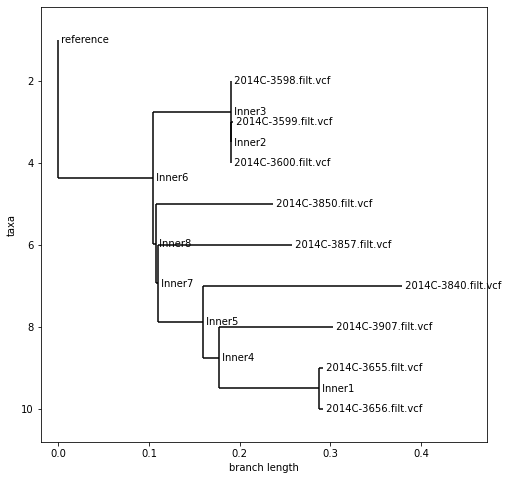

In [73]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
import matplotlib.pyplot as plt

calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')
tree = constructor.build_tree(alignment)
tree.root_with_outgroup('reference')
tree.ladderize()

plt.rcParams['figure.figsize'] = (8,8)
Bio.Phylo.draw(tree)

# Test incrementally building tree

0.9186180391768523
Alignment with 4 rows and 93 columns
TACGATCGTAGCTAGGCGGCCGTACGCAAGAAAAAATTTAGAGG...GCA 2014C-3600.filt.vcf
TACGATCGTAGCTAGGCGGCCGTACGCAAGAAAAAATTTAGAGG...GCA 2014C-3598.filt.vcf
TACGATCGTAGTTAGGCGGCCGTACGCAAGAAAAAATTTAGAGG...GCA 2014C-3599.filt.vcf
CGTAGCTACCACCGAATTATGACTTATGGTGGGGTTCACGACAA...ATC reference


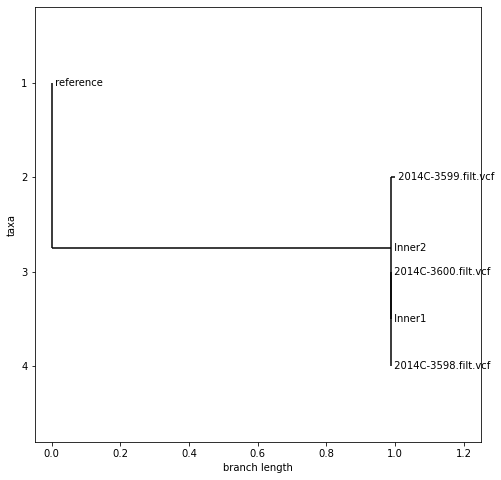

In [97]:
from biocommons.seqrepo import SeqRepo
import ga4gh.vrs.dataproxy as dataproxy

from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
import matplotlib.pyplot as plt

def vcf_paths(samples):
    return [os.path.join('data/snps-vcf', s + '.filt.vcf') for s in samples]

def ref_align_paths(samples):
    return [os.path.join('data/snps-aligned', s + '.aligned.fa') for s in samples]

sr = SeqRepo("data/references")
ref_proxy = dataproxy.SeqRepoDataProxy(sr)

core_masks = BitMaskManager()
vr = VariantsReader()

samples = ['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655',
           '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907']
samples = samples[:3]

core_masks.add_genomes(ref_align_paths(samples))
variants_df = vr.read_vcfs(vcf_paths(samples))
align_constructor = CoreAlignmentConstructor(core_masks, ref_proxy)
alignment = align_constructor.construct_alignment(variants_df[variants_df['TYPE'] == 'snp'])
print(core_masks.core_proportion())
print(alignment)

calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')
tree = constructor.build_tree(alignment)
tree.root_with_outgroup('reference')
tree.ladderize()

plt.rcParams['figure.figsize'] = (8,8)
Bio.Phylo.draw(tree)

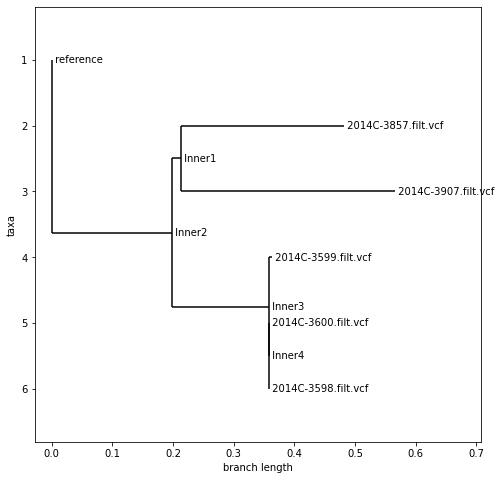

In [98]:
samples = ['2014C-3857', '2014C-3907']
core_masks.add_genomes(ref_align_paths(samples))
new_df = pd.concat([variants_df, vr.read_vcfs(vcf_paths(samples))])
align_constructor = CoreAlignmentConstructor(core_masks, ref_proxy)
alignment = align_constructor.construct_alignment(new_df[new_df['TYPE'] == 'snp'])

tree = constructor.build_tree(alignment)
tree.root_with_outgroup('reference')
tree.ladderize()

plt.rcParams['figure.figsize'] = (8,8)
Bio.Phylo.draw(tree)